In [1]:
import imageio

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img,img_to_array,load_img
import scipy.misc
from imutils.object_detection import non_max_suppression
import argparse
import time
from PIL import Image
import operator
import os,io
from scipy import stats
#from scipy.misc import imsave

In [3]:
def shape_detection(pic):
    img = img_to_array(load_img(pic))
    x=img.shape[0]
    y=img.shape[1]
    X=[]
    Y=[]
    for i in range(x-1):
        for j in range(y-1):
            r=img[i][j][0]
            b=img[i][j][2]
            g=img[i][j][1]
            if b-r>40 and b-g>40:
                X.append(i)
                Y.append(j)
                X.sort()
                Y.sort()
    x_min = X[0]
    x_max = X[-1]
    y_min = Y[0]
    y_max = Y[-1]
    pix=[]
    for i in range(x_min,x_max+1):
        for j in range(y_min,y_max+1):
            pix.append(img[i][j].tolist())
        
    xval = x_max - x_min+1
    yval = y_max - y_min+1
    P=np.array(pix)
    P0=P.reshape((xval,yval,3))
    imageio.imwrite('red.jpg', P0)
    #scipy.misc.imsave('red.jpg',P0)
    


In [4]:
def text():
    
    image = cv2.imread('red.jpg')
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    orig = image.copy()

    (H, W) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    print("[INFO] loading EAST text detector...")
    net = cv2.dnn.readNet('frozen_east_text_detection.pb')

    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] <0.5:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # loop over the bounding boxes
    if len(boxes)!=0:
        for (startX, startY, endX, endY) in boxes:
            # scale the bounding box coordinates based on the respective
            # ratios
            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)
        #r = cv2.resize(orig[startY:endY,startX:endX], (100,100), interpolation = cv2.INTER_AREA)
        plt.imsave('text.jpg',orig[startY-10:endY+10,startX-10:endX+60])
        fun('text.jpg')
    else:
        plt.imsave('text.jpg',orig)
        fun('text.jpg')
def fun(img):
    a=img_to_array(load_img(img))
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if a[i][j][2]-a[i][j][0]>15 and a[i][j][2]-a[i][j][1]>15:
                a[i][j]=[221,221,221]
    imageio.imwrite("imax.jpg",a)
    ai=cv2.imread('imax.jpg')
    ai=cv2.cvtColor(ai,cv2.COLOR_BGR2GRAY)
    et,out=cv2.threshold(ai,127,255,cv2.THRESH_BINARY,cv2.THRESH_OTSU)
    plt.imshow(out,cmap='gray')
    imageio.imwrite("ipure.jpg",out)
        

In [5]:
def train(train_img):
    MIN_CONTOUR_AREA = 100

    RESIZED_IMAGE_WIDTH = 20
    RESIZED_IMAGE_HEIGHT = 30
    imgTrainingNumbers = cv2.imread(train_img)            # read in training numbers image
    
    if imgTrainingNumbers is None:                          # if image was not read successfully
        print ("error: image not read from file \n\n")        # print error message to std out
        os.system("pause")                                  # pause so user can see error message
        return                                              # and exit function (which exits program)
    # end if

    imgGray = cv2.cvtColor(imgTrainingNumbers, cv2.COLOR_BGR2GRAY)          # get grayscale image
    imgBlurred = cv2.GaussianBlur(imgGray, (5,5), 0)                        # blur

                                                        # filter image from grayscale to black and white
    imgThresh = cv2.adaptiveThreshold(imgBlurred,                           # input image
                                      255,                                  # make pixels that pass the threshold full white
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,       # use gaussian rather than mean, seems to give better results
                                      cv2.THRESH_BINARY_INV,                # invert so foreground will be white, background will be black
                                      11,                                   # size of a pixel neighborhood used to calculate threshold value
                                      2)                                    # constant subtracted from the mean or weighted mean

    cv2.imshow("imgThresh", imgThresh)      # show threshold image for reference

    imgThreshCopy = imgThresh.copy()        # make a copy of the thresh image, this in necessary b/c findContours modifies the image

    npaContours, npaHierarchy = cv2.findContours(imgThreshCopy,        # input image, make sure to use a copy since the function will modify this image in the course of finding contours
                                                 cv2.RETR_EXTERNAL,                 # retrieve the outermost contours only
                                                 cv2.CHAIN_APPROX_SIMPLE)           # compress horizontal, vertical, and diagonal segments and leave only their end points

                                # declare empty numpy array, we will use this to write to file later
                                # zero rows, enough cols to hold all image data
    npaFlattenedImages =  np.empty((0, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))

    intClassifications = []         # declare empty classifications list, this will be our list of how we are classifying our chars from user input, we will write to file at the end

                                    # possible chars we are interested in are digits 0 through 9, put these in list intValidChars
    intValidChars = [ord('0'), ord('1'), ord('2'), ord('3'), ord('4'), ord('5'), ord('6'), ord('7'), ord('8'), ord('9'),
                     ord('A'), ord('B'), ord('C'), ord('D'), ord('E'), ord('F'), ord('G'), ord('H'), ord('I'), ord('J'),
                     ord('K'), ord('L'), ord('M'), ord('N'), ord('O'), ord('P'), ord('Q'), ord('R'), ord('S'), ord('T'),
                     ord('U'), ord('V'), ord('W'), ord('X'), ord('Y'), ord('Z'),ord(' ')]

    for npaContour in npaContours:                          # for each contour
        if cv2.contourArea(npaContour) > MIN_CONTOUR_AREA:          # if contour is big enough to consider
            [intX, intY, intW, intH] = cv2.boundingRect(npaContour)         # get and break out bounding rect

                                                # draw rectangle around each contour as we ask user for input
            cv2.rectangle(imgTrainingNumbers,           # draw rectangle on original training image
                          (intX, intY),                 # upper left corner
                          (intX+intW,intY+intH),        # lower right corner
                          (0, 0, 255),                  # red
                          2)                            # thickness

            imgROI = imgThresh[intY:intY+intH, intX:intX+intW]                                  # crop char out of threshold image
            imgROIResized = cv2.resize(imgROI, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))     # resize image, this will be more consistent for recognition and storage
            
            cv2.imshow("imgROI", imgROI)# show cropped out char for reference
            
            cv2.imshow("imgROIResized", imgROIResized)# show resized image for reference
            
            cv2.imshow("training_numbers.png", imgTrainingNumbers)      # show training numbers image, this will now have red rectangles drawn on it
            
            intChar = cv2.waitKey(0)                     # get key press

            if intChar == 27:                   # if esc key was pressed
                sys.exit()                      # exit program
            elif intChar in intValidChars:      # else if the char is in the list of chars we are looking for . . .

                intClassifications.append(intChar)                                                # append classification char to integer list of chars (we will convert to float later before writing to file)

                npaFlattenedImage = imgROIResized.reshape((1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))  # flatten image to 1d numpy array so we can write to file later
                npaFlattenedImages = np.append(npaFlattenedImages, npaFlattenedImage, 0)                    # add current flattened impage numpy array to list of flattened image numpy arrays
            # end if
        # end if
    # end for

    fltClassifications = np.array(intClassifications, np.float32)                   # convert classifications list of ints to numpy array of floats

    npaClassifications = fltClassifications.reshape((fltClassifications.size, 1))   # flatten numpy array of floats to 1d so we can write to file later
    
    a=[]
    print ("\n\ntraining complete !!\n")
    
     
    np.savetxt("classifications.txt", npaClassifications)           # write flattened images to file
    
    #a1=np.loadtxt("classifications.txt")
    
    #np.savetxt("classifications.txt",np.hstack((a1,npaClassifications.flatten())))
    
    np.savetxt("flattened_images.txt", npaFlattenedImages)          #
    #a1=np.loadtxt("flattened_images.txt")
   
    #np.savetxt("flattened_images.txt",np.vstack((a1,npaFlattenedImages)))
    #print((np.vstack((a1,npaFlattenedImages))).shape)
    

    cv2.destroyAllWindows()             # remove windows from memory

    return

In [6]:
MIN_CONTOUR_AREA = 50

RESIZED_IMAGE_WIDTH = 20
RESIZED_IMAGE_HEIGHT = 30

###################################################################################################
class ContourWithData():

    # member variables ############################################################################
    npaContour = None           # contour
    boundingRect = None         # bounding rect for contour
    intRectX = 0                # bounding rect top left corner x location
    intRectY = 0                # bounding rect top left corner y location
    intRectWidth = 0            # bounding rect width
    intRectHeight = 0           # bounding rect height
    fltArea = 0.0               # area of contour

    def calculateRectTopLeftPointAndWidthAndHeight(self):               # calculate bounding rect info
        [intX, intY, intWidth, intHeight] = self.boundingRect
        self.intRectX = intX
        self.intRectY = intY
        self.intRectWidth = intWidth
        self.intRectHeight = intHeight

    def checkIfContourIsValid(self):                            # this is oversimplified, for a production grade program
        if self.fltArea < MIN_CONTOUR_AREA: return False        # much better validity checking would be necessary
        return True

###################################################################################################
def main():
    allContoursWithData = []                # declare empty lists,
    validContoursWithData = []              # we will fill these shortly

    try:
        npaClassifications = np.loadtxt("classifications.txt", np.float32)                  # read in training classifications
    except:
        print ("error, unable to open classifications.txt, exiting program\n")
        os.system("pause")
        return
    # end try

    try:
        npaFlattenedImages = np.loadtxt("flattened_images.txt", np.float32)                 # read in training images
    except:
        print ("error, unable to open flattened_images.txt, exiting program\n")
        os.system("pause")
        return
    # end try

    npaClassifications = npaClassifications.reshape((npaClassifications.size, 1))       # reshape numpy array to 1d, necessary to pass to call to train

    kNearest = cv2.ml.KNearest_create()                   # instantiate KNN object

    kNearest.train(npaFlattenedImages, cv2.ml.ROW_SAMPLE, npaClassifications)

    imgTestingNumbers = cv2.imread('ipure.jpg')          # read in testing numbers image

    if imgTestingNumbers is None:                           # if image was not read successfully
        print ("error: image not read from file \n\n" )       # print error message to std out
        os.system("pause")                                  # pause so user can see error message
        return                                              # and exit function (which exits program)
    # end if

    imgGray = cv2.cvtColor(imgTestingNumbers, cv2.COLOR_BGR2GRAY)       # get grayscale image
    imgBlurred = cv2.GaussianBlur(imgGray, (5,5), 0)                    # blur

                                                        # filter image from grayscale to black and white
    imgThresh = cv2.adaptiveThreshold(imgBlurred,                           # input image
                                      255,                                  # make pixels that pass the threshold full white
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,       # use gaussian rather than mean, seems to give better results
                                      cv2.THRESH_BINARY_INV,                # invert so foreground will be white, background will be black
                                      11,                                   # size of a pixel neighborhood used to calculate threshold value
                                      2)                                    # constant subtracted from the mean or weighted mean

    imgThreshCopy = imgThresh.copy()        # make a copy of the thresh image, this in necessary b/c findContours modifies the image

    npaContours, npaHierarchy = cv2.findContours(imgThreshCopy,             # input image, make sure to use a copy since the function will modify this image in the course of finding contours
                                                 cv2.RETR_EXTERNAL,         # retrieve the outermost contours only
                                                 cv2.CHAIN_APPROX_SIMPLE)   # compress horizontal, vertical, and diagonal segments and leave only their end points

    for npaContour in npaContours:                             # for each contour
        contourWithData = ContourWithData()                                             # instantiate a contour with data object
        contourWithData.npaContour = npaContour                                         # assign contour to contour with data
        contourWithData.boundingRect = cv2.boundingRect(contourWithData.npaContour)     # get the bounding rect
        contourWithData.calculateRectTopLeftPointAndWidthAndHeight()                    # get bounding rect info
        contourWithData.fltArea = cv2.contourArea(contourWithData.npaContour)           # calculate the contour area
        allContoursWithData.append(contourWithData)                                     # add contour with data object to list of all contours with data
    # end for

    for contourWithData in allContoursWithData:                 # for all contours
        if contourWithData.checkIfContourIsValid():             # check if valid
            validContoursWithData.append(contourWithData)       # if so, append to valid contour list
        # end if
    # end for

    validContoursWithData.sort(key = operator.attrgetter("intRectX"))         # sort contours from left to right

    strFinalString = ""         # declare final string, this will have the final number sequence by the end of the program
    l=[]
    ll=[]
    for contourWithData in validContoursWithData:            # for each contour
        l.append((contourWithData.intRectX ))
        ll.append((contourWithData.intRectWidth*contourWithData.intRectHeight))
    
    w=l[1]-l[0]
    V=0
    for i in range(1,len(l)):
        if l[i]-l[i-1]>=w+15:
            V=i
           
    c=0
    for contourWithData in validContoursWithData:            # for each contour
        if c!=V:# draw a green rect around the current char
            cv2.rectangle(imgTestingNumbers,                                        # draw rectangle on original testing image
                          (contourWithData.intRectX, contourWithData.intRectY),     # upper left corner
                          (contourWithData.intRectX + contourWithData.intRectWidth, contourWithData.intRectY + contourWithData.intRectHeight),      # lower right corner
                          (0, 255, 0),              # green
                          2)   
        else:
            cv2.rectangle(imgTestingNumbers,                                        # draw rectangle on original testing image
                          (contourWithData.intRectX, contourWithData.intRectY),     # upper left corner
                          (contourWithData.intRectX + contourWithData.intRectWidth, contourWithData.intRectY + contourWithData.intRectHeight),      # lower right corner
                          (0, 0, 255),              # green
                          2) 
            
            strFinalString = strFinalString + "."   
        c=c+1
            
         

        imgROI = imgThresh[contourWithData.intRectY : contourWithData.intRectY + contourWithData.intRectHeight,     # crop char out of threshold image
                           contourWithData.intRectX : contourWithData.intRectX + contourWithData.intRectWidth]
       
        #cv2.imshow("imgTestingNumbers", imgROI)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows() 
        imgROIResized = cv2.resize(imgROI, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))             # resize image, this will be more consistent for recognition and storage

        npaROIResized = imgROIResized.reshape((1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))      # flatten image into 1d numpy array

        npaROIResized = np.float32(npaROIResized)       # convert from 1d numpy array of ints to 1d numpy array of floats

        retval, npaResults, neigh_resp, dists = kNearest.findNearest(npaROIResized, k = 1)     # call KNN function find_nearest

        strCurrentChar = str(chr(int(npaResults[0][0])))                                             # get character from results
        
        strFinalString = strFinalString + strCurrentChar  
        # append current char to full string
    # end for
    
    
            
    if strFinalString[0]=='.':
        print ("\n" + strFinalString[1:] + "\n")  # show the full string
    else:
        print(print ("\n" + strFinalString[:] + "\n"))
    print(l)
    print(ll)
    print(np.array(ll).mean())
    print(stats.mode(ll))
    cv2.imshow("imgTestingNumbers", imgTestingNumbers)      # show input image with green boxes drawn around found digits
    cv2.waitKey(0)                                          # wait for user key press
    
    cv2.destroyAllWindows()             # remove windows from memory

    return

###################################################################################################
def RUN(img):
    if __name__ == "__main__":
        pic = img
        shape_detection(pic)
        text()
        main()
    
    

    

Lossy conversion from float64 to uint8. Range [18.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


[INFO] loading EAST text detector...


Lossy conversion from float32 to uint8. Range [0.0, 248.0]. Convert image to uint8 prior to saving to suppress this warning.


[INFO] text detection took 0.231774 seconds

199.5

None
[3, 32, 61, 116]
[704, 630, 630, 690]
663.5
ModeResult(mode=array([630]), count=array([2]))


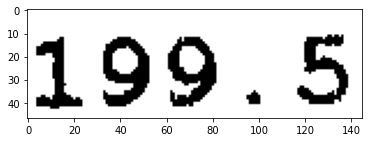

In [7]:
path='22.jpeg' 
RUN(path)